In [1]:
import numpy as np
import pandas as pd
import scipy.io 
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

infmask = scipy.io.loadmat("/content/drive/MyDrive/AIMIA/Assignment-1/infmsk_hw1.mat")

ctscan = scipy.io.loadmat("/content/drive/MyDrive/AIMIA/Assignment-1/ctscan_hw1.mat")

Mounted at /content/drive


In [3]:
infmask_data = infmask['infmsk']
ctscan_data = ctscan['ctscan']

K-means using OpenCV

In [4]:
def kmeans_seg_img(original_image):
  original_image = (original_image - np.mean(original_image)) / np.std(original_image)

  vectorized = original_image.reshape(-1)

  vectorized = np.float32(vectorized)

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)

  K = 3
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)

  res = center[label.flatten()]

  unique, counts = np.unique(res,  return_counts=True)
  # print("before",unique, counts)
  s_2 = unique[1]

  if len(unique) == 3:
    s_1 = unique[2]

  res[np.where(res==s_2)]=2
  if len(unique) == 3:
    res[np.where(res==s_1)]=1

  # a_unique, a_counts = np.unique(res,  return_counts=True)
  # print("after", a_unique, a_counts)
  result_image = res.reshape((original_image.shape))

  return result_image

In [5]:
predicted = []
from tqdm import tqdm
for i in tqdm(range(0, 500)): #0,3553
  predicted.append(kmeans_seg_img(ctscan_data[:,:,i]))


predicted = np.array(predicted)

# predicted.shape
pred = np.transpose(predicted, [2,1,0])
pred.shape

100%|██████████| 500/500 [02:20<00:00,  3.56it/s]


(512, 512, 500)

In [6]:
# to get limited samples running
infmask = []

for i in range(0,500):
  infmask.append(infmask_data[:,:,i])

infmask = np.array(infmask)
infmask = np.transpose(infmask, [2,1,0])
infmask.shape

(512, 512, 500)

In [7]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(infmask.flatten().astype(int),pred.flatten().astype(int))

# print(cnf_mat)
dice = 2*cnf_mat[1,1]/(2*cnf_mat[1,1]+(cnf_mat[0,1]+cnf_mat[2,1])+(cnf_mat[1,0]+cnf_mat[1,2]))
dice

0.2549958857147646

In [8]:
from sklearn.metrics import classification_report
infmask_f = infmask.flatten()
predict_f = pred.flatten()
print(classification_report(infmask_f,predict_f))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00 118656412
           1       0.18      0.45      0.25    943633
           2       0.96      0.80      0.87  11471955

    accuracy                           0.98 131072000
   macro avg       0.71      0.75      0.71 131072000
weighted avg       0.99      0.98      0.98 131072000



In [9]:
#Specificity = TN/(TN+FP)
spec_for_normal = (cnf_mat[0,0]+cnf_mat[0,1]+cnf_mat[1,0]+cnf_mat[1,1])/(cnf_mat[0,0]+cnf_mat[0,1]+cnf_mat[1,0]+cnf_mat[1,1]+cnf_mat[0,2]+cnf_mat[1,2])
spec_for_infected = (cnf_mat[0,0]+cnf_mat[0,2]+cnf_mat[2,0]+cnf_mat[2,2])/(cnf_mat[0,0]+cnf_mat[0,2]+cnf_mat[2,0]+cnf_mat[2,2]+cnf_mat[0,1]+cnf_mat[2,1])
print('Specificity for normal',spec_for_normal)
print('Specificity for infected',spec_for_infected)


Specificity for normal 0.9966477437362168
Specificity for infected 0.9848517195332206


In [10]:
#Accuracy = (TP+TN)/(All points)
acc_for_normal = (cnf_mat[2,2]+cnf_mat[0,0]+cnf_mat[0,1]+cnf_mat[1,0]+cnf_mat[1,1])/(np.sum(cnf_mat))
acc_for_infected = (cnf_mat[1,1]+cnf_mat[0,0]+cnf_mat[0,2]+cnf_mat[2,0]+cnf_mat[2,2])/(np.sum(cnf_mat))
print('Accuracy for normal region',acc_for_normal)
print('Accuracy for infected region', acc_for_infected)

Accuracy for normal region 0.9794646530151367
Accuracy for infected region 0.9810111312866211


For whole dataset (3554), output from GPU

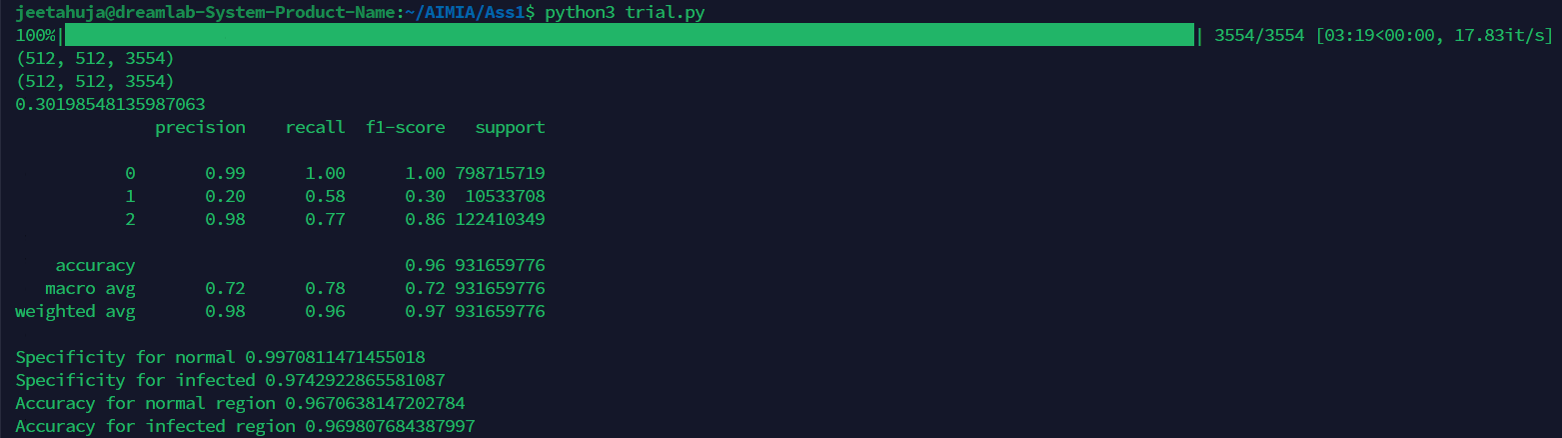

In [13]:
from IPython import display
display.Image("/content/drive/MyDrive/AIMIA/Assignment-1/q2_op.png")